# 1. CNN para predecir el precio de las casas Boston Housing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install tensorflow keras seaborn

In [ ]:
### Importar las bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import concatenate
from keras.utils import plot_model
from keras.layers import Input

# # Leer el archivo CSV
# df = pd.read_csv('Housing.csv')

# # Mostrar las primeras filas del DataFrame
# print(df.head())

leer el dataset, convertir las variables categóricas (tanto binarias como multi-clase), separar las features y la variable objetivo, realizar la división en entrenamiento/prueba, escalar las variables y finalmente reestructurar los datos para cumplir con el input requerido por una CNN (forma: *samples, timesteps, features*).


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# ### Preprocesamiento de Datos
# Se procesan las variables categóricas, se dividen los datos en entrenamiento y prueba, se escalan y se reestructuran para la CNN.

# Leer el dataset
df = pd.read_csv('/content/drive/MyDrive/ITESO/6-semestre/MPST/Housing.csv')
print("Primeras filas del dataset:")
print(df.head())

Primeras filas del dataset:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  




- Tenemos columnas tanto numéricas (price, area, bedrooms, bathrooms, stories, parking) como categóricas (mainroad, guestroom, basement, hotwaterheating, airconditioning, prefarea, furnishingstatus).
- Las columnas binarias (ej. mainroad, guestroom, etc.) se convertirán a valores numéricos (1 para "yes", 0 para "no").
- Se aplicará one-hot encoding a la columna "furnishingstatus" para tratar sus categorías de forma adecuada.
- Posteriormente, se dividirán los datos en conjuntos de entrenamiento y prueba, se escalarán las features y se reestructurarán para cumplir con el formato de entrada de una CNN (samples, timesteps, features).


In [ ]:
# Convertir columnas binarias (yes/no) a numéricas
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
binary_map = {'yes': 1, 'no': 0}
for col in binary_cols:
    df[col] = df[col].map(binary_map)

# Para 'furnishingstatus', aplicar one-hot encoding (drop_first para evitar multicolinealidad)
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)

# Separar features (X) y target (y)
X = df.drop('price', axis=1)
y = df['price']

# División de los datos: 80% entrenamiento, 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalado de las features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape para CNN: cada muestra se reestructura a (n_features, 1)
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print("Forma de los datos de entrenamiento para la CNN:", X_train_cnn.shape)

Forma de los datos de entrenamiento para la CNN: (436, 13, 1)


---

**CeConstrucción y Entrenamiento del Modelo CNN**  
Definir la arquitectura de la CNN usando dos capas de convolución y pooling, seguidas de un aplanado, una capa densa intermedia (con Dropout para regularización) y la capa de salida para regresión. Se compila el modelo y se entrena utilizando *EarlyStopping* para evitar sobreajuste.

In [ ]:
# ### Construcción y Entrenamiento del Modelo CNN
# Se define una arquitectura CNN con capas Conv1D, MaxPooling, Flatten, Dense y Dropout para regresión en precio de viviendas.

n_timesteps = X_train_cnn.shape[1]

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(n_timesteps, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Entrenamiento con EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stop])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 12, 32)              │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 6, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,865 (97.13 KB)

 Trainable params: 24,865 (97.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 25125057462272.0000 - mae: 4706790.5000 - val_loss: 24781571227648.0000 - val_mae: 4623894.5000
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 25555757957120.0000 - mae: 4761731.0000 - val_loss: 24781483147264.0000 - val_mae: 4623885.0000
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 27627572166656.0000 - mae: 4913195.0000 - val_loss: 24781265043456.0000 - val_mae: 4623862.0000
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 24865276952576.0000 - mae: 4675073.0000 - val_loss: 24780795281408.0000 - val_mae: 4623812.5000
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 25623909105664.0000 - mae: 4755133.5000 - val_loss: 24779878825984.0000 - val_mae: 4623716.5000
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 26962529615872.0000 - mae: 4840024.0000 - val_loss: 24778234658816.0000 - val_mae: 4623544.0000
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2459


Evaluación y Visualización del Historial de Entrenamiento**
Evaluar el modelo en el conjunto de prueba y genera gráficas para visualizar la evolución de la pérdida (MSE) y el MAE en entrenamiento y validación.

In [ ]:
# ### Evaluación del Modelo y Visualización del Historial de Entrenamiento
# Se evalúa el modelo en el conjunto de prueba y se grafican las métricas de entrenamiento y validación.

# %% Código
loss, mae = model.evaluate(X_test_cnn, y_test)
print("Test Loss (MSE):", loss)
print("Test MAE:", mae)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3450269335552.0000 - mae: 1355356.2500 
Test Loss (MSE): 3297359167488.0
Test MAE: 1303123.875


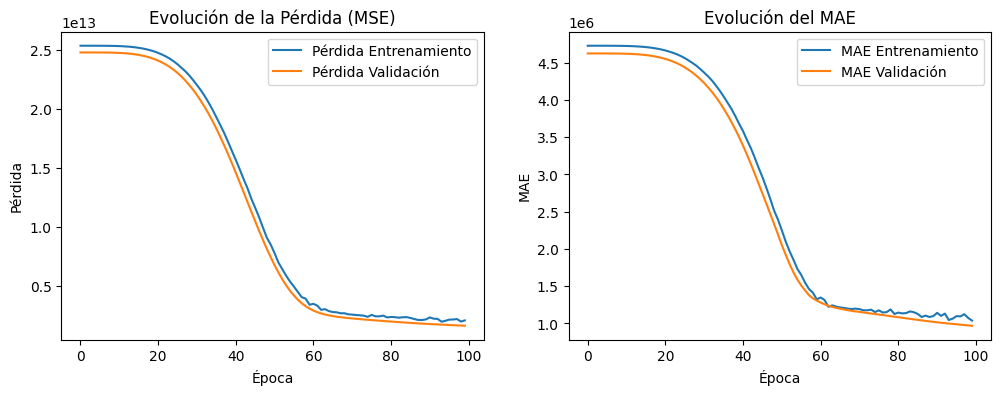

In [ ]:
# Graficar la evolución del entrenamiento
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.title("Evolución de la Pérdida (MSE)")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE Entrenamiento')
plt.plot(history.history['val_mae'], label='MAE Validación')
plt.title("Evolución del MAE")
plt.xlabel("Época")
plt.ylabel("MAE")
plt.legend()

plt.show()

### Resultados y POSIBLES pasos siguienyes

1. **Pérdida (MSE) y MAE**  
   - El **MSE** en la prueba (~3.30×10¹²) indica el orden de magnitud del error cuadrático medio.  
   - El **MAE** (~1.30×10⁶) significa que, en promedio, el modelo se desvía en ~1.3 millones de la etiqueta real. Dado que los precios pueden rondar decenas de millones, es un error que podría ser mejorado con mas ajustes.

2. **Curvas de Entrenamiento/Validación**  
   - Las curvas de pérdida y MAE para entrenamiento y validación son similares, lo que sugiere que no hay sobreajuste severo. El modelo converge de forma estable.

3. **Siguiente paso**  
   - Para una mejor interpretación, es útil ver las predicciones vs. valores reales en el conjunto de prueba.  
   - También podemos considerar transformaciones (por ejemplo, aplicar log a la variable objetivo) o una búsqueda de hiperparámetros más exhaustiva para mejorar la precisión.

---


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


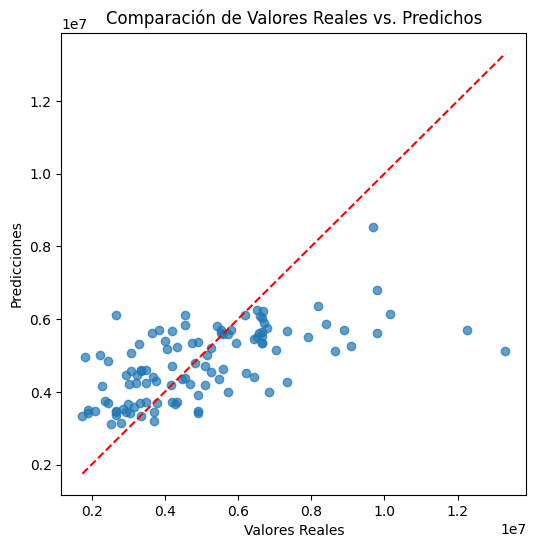

      Real    Predicho
0  4060000  5172703.00
1  6650000  5357131.50
2  3710000  3451437.50
3  6440000  4415863.50
4  2800000  3144337.50
5  4900000  3478506.75
6  5250000  4538116.50
7  4543000  5847862.00
8  2450000  4850739.50
9  3353000  3346862.50


In [ ]:
# Realizamos la predicción sobre el conjunto de prueba y comparamos los valores
# reales vs. predichos con un scatter plot para observar la correlación.

# %% Código
y_pred = model.predict(X_test_cnn)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación de Valores Reales vs. Predichos')
plt.show()

# Mostrar algunas filas para inspección
comparison_df = pd.DataFrame({'Real': y_test.values, 'Predicho': y_pred.flatten()})
print(comparison_df.head(10))


### Interpretación de las Predicciones vs. Valores Reales

1. **Dispersión de Puntos**  
   - El diagrama muestra que las predicciones tienden a agruparse alrededor de la diagonal, aunque se observan desviaciones importantes en valores altos y bajos.
   - Por ejemplo, para precios más bajos (p. ej., ~2.45 millones), el modelo sobreestima; para precios más altos (p. ej., ~6.44 millones), subestima.

2. **Errores en el DataFrame**  
   - Observando el DataFrame de comparación, vemos diferencias de ±1 a ±2 millones en algunos casos.  
   - Dado que los precios se encuentran en el rango de varios millones, podría ser que una aproximación en valores absolutos resulte grande, pero en términos relativos (porcentaje de error) sea menos severo. Aun así, es deseable refinar el modelo.

3. **Posibles Acciones de Mejora**  
   - **Aplicar Transformaciones**: Un enfoque común es entrenar el modelo con la variable objetivo en escala logarítmica. Esto puede ayudar a que el modelo capture mejor relaciones en un rango amplio de precios.  
   - **Tuning de Hiperparámetros**: Ajustar número de filtros en Conv1D, capas adicionales, learning rate, batch size, o usar más épocas con `EarlyStopping`.  
   - **Feature Engineering**: Incluir más características o interacciones relevantes (por ejemplo, ratios o variables polinómicas) si se dispone de más información.  
   - **Regularización Adicional**: Añadir capas de Dropout en puntos estratégicos o modificar el factor de dropout para evitar subajuste o sobreajuste.  

---

Aplicaremos la **transformación logarítmica** sobre la columna `price`, entrenaremos el modelo y luego invierte la transformación para evaluar el desempeño en la escala original.


In [ ]:
### Celda Extra – Entrenamiento con Transformación Logarítmica
# Se transformará la variable objetivo (price) con log, se re-entrena la CNN,
# y se revierten las predicciones para evaluar en la escala original.


# 1. Cargar el dataset original
df_log = pd.read_csv('/content/drive/MyDrive/ITESO/6-semestre/MPST/Housing.csv')

# 2. Convertir variables categóricas binarias
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
binary_map = {'yes': 1, 'no': 0}
for col in binary_cols:
    df_log[col] = df_log[col].map(binary_map)

# 3. One-hot encoding para 'furnishingstatus'
df_log = pd.get_dummies(df_log, columns=['furnishingstatus'], drop_first=True)

# 4. Aplicar log a la variable objetivo
df_log['price_log'] = np.log(df_log['price'])

# 5. Separar X e y
X_log = df_log.drop(['price', 'price_log'], axis=1)
y_log = df_log['price_log']

# 6. División train/test
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

# 7. Escalado
scaler_log = StandardScaler()
X_train_log_scaled = scaler_log.fit_transform(X_train_log)
X_test_log_scaled = scaler_log.transform(X_test_log)

# 8. Reshape para CNN
X_train_log_cnn = X_train_log_scaled.reshape(X_train_log_scaled.shape[0], X_train_log_scaled.shape[1], 1)
X_test_log_cnn = X_test_log_scaled.reshape(X_test_log_scaled.shape[0], X_test_log_scaled.shape[1], 1)

# 9. Definir modelo CNN
model_log = Sequential()
model_log.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train_log_cnn.shape[1], 1)))
model_log.add(MaxPooling1D(pool_size=2))
model_log.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model_log.add(Flatten())
model_log.add(Dense(64, activation='relu'))
model_log.add(Dropout(0.2))
model_log.add(Dense(1))

model_log.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 10. Entrenamiento
early_stop_log = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_log = model_log.fit(X_train_log_cnn, y_train_log,
                            validation_split=0.2,
                            epochs=100,
                            batch_size=32,
                            callbacks=[early_stop_log],
                            verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Loss (MSE) en escala log: 0.2503508925437927
Test MAE en escala log: 0.36111435294151306


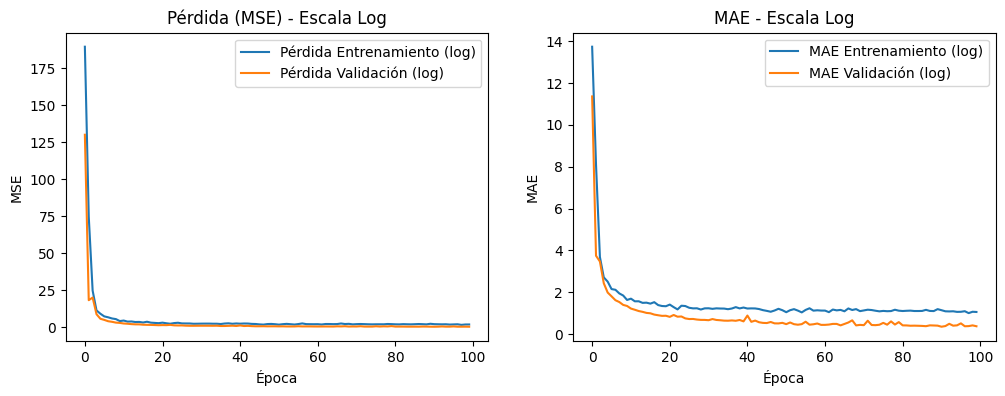

In [ ]:
# 11. Evaluación en el conjunto de prueba (en la escala log)
loss_log, mae_log = model_log.evaluate(X_test_log_cnn, y_test_log, verbose=0)
print("Test Loss (MSE) en escala log:", loss_log)
print("Test MAE en escala log:", mae_log)

# 12. Visualización de métricas de entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_log.history['loss'], label='Pérdida Entrenamiento (log)')
plt.plot(history_log.history['val_loss'], label='Pérdida Validación (log)')
plt.title("Pérdida (MSE) - Escala Log")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_log.history['mae'], label='MAE Entrenamiento (log)')
plt.plot(history_log.history['val_mae'], label='MAE Validación (log)')
plt.title("MAE - Escala Log")
plt.xlabel("Época")
plt.ylabel("MAE")
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
MAE en escala original: 2286509.1077981642


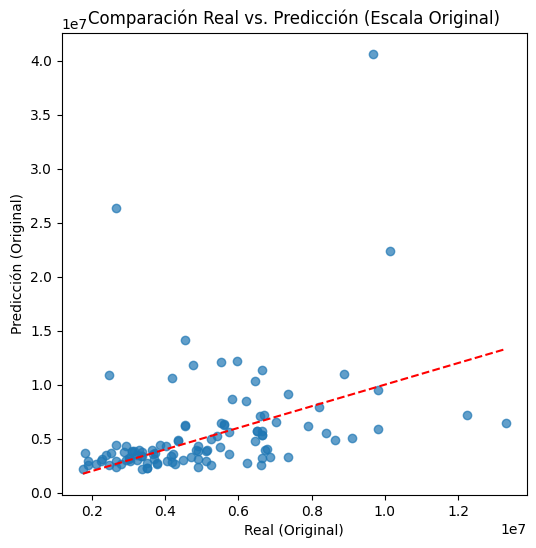

In [ ]:
# 13. Predicciones en escala log y reconversión a escala original
y_pred_log = model_log.predict(X_test_log_cnn).flatten()
y_pred_original = np.exp(y_pred_log)  # revertir log
y_test_original = np.exp(y_test_log.values)

# 14. Cálculo de MAE en la escala original
mae_original = np.mean(np.abs(y_test_original - y_pred_original))
print("MAE en escala original:", mae_original)

# 15. Visualizar comparación
plt.figure(figsize=(6,6))
plt.scatter(y_test_original, y_pred_original, alpha=0.7)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()], 'r--')
plt.xlabel('Real (Original)')
plt.ylabel('Predicción (Original)')
plt.title('Comparación Real vs. Predicción (Escala Original)')
plt.show()

### Conclusiones y POSIBLESS pasos siguientes

1. **Resultados con Transformación Logarítmica**  
   - En la **escala log**, se obtuvo un MSE ~0.25 y MAE ~0.36.  
   - Al revertir las predicciones a la escala original, el **MAE** resultó ~2.29 millones, mayor que el ~1.30 millones obtenido sin transformación.  
   - Esto indica que, para **error absoluto**, la transformación logarítmica no mejoró los resultados en este caso.

2. **Interpretación**  
   - Es posible que la transformación logarítmica **mejore la precisión relativa** (para casas muy caras o muy baratas) pero incremente el error absoluto medio.  
   - El desempeño de la red también depende de la arquitectura, hiperparámetros y la distribución de precios. Si el dataset contiene outliers o rangos amplios, la log-transform puede ser útil para reducir la influencia de valores extremos en el entrenamiento; sin embargo, no siempre garantiza una menor desviación absoluta.

3. **Siguientes Pasos**  
   1. **Evaluar Métricas Relativas**: Por ejemplo, **MAPE** (Mean Absolute Percentage Error) o **SMAPE** para juzgar la precisión en términos de porcentaje. La escala log puede comportarse mejor en esos criterios.  
   2. **Búsqueda de Hiperparámetros**:  
      - Ajustar número de filtros, capas, tamaño de kernel en `Conv1D`, factor de dropout, batch size, learning rate, etc.  
      - Probar un número mayor de épocas (con `EarlyStopping`) o un `patience` distinto.  
   3. **Feature Engineering**: Incluir interacciones entre variables (por ejemplo, `area * bedrooms`), variables polinómicas.
   4. **Regularización y/o Arquitecturas Híbridas**:  
      - Añadir más capas `Dropout` o `L2 regularization`.  
      - Experimentar con modelos híbridos (CNN + MLP, por
         - Experimentar con modelos híbridos (CNN + MLP, por ejemplo) o probar **RNN/LSTM** si hubiera alguna secuencia temporal implícita (no parece el caso, pero es otra vía).  
   5. **Comparar con Modelos Clásicos**:  
      - Un **Random Forest** o **XGBoost** podría servir de baseline para ver si la CNN aporta verdadera ventaja.  
      - Calcular error promedio, varianza de errores, etc., para una visión más amplia de la calidad de las predicciones.

La CNN actual funciona razonablemente en términos de convergencia, pero podemos explorar ajustes y métricas adicionales para mejorar o reinterpretar los resultados, en particular si el objetivo del exige reducir el error absoluto o el error relativo.


In [ ]:
### Búsqueda Manual de Hiperparámetros

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Usaremos el mismo split de entrenamiento X_train_cnn, y_train y
# definiremos manualmente un subconjunto para validación (80/20) dentro de train.
split_idx = int(0.8 * X_train_cnn.shape[0])
X_t, X_v = X_train_cnn[:split_idx], X_train_cnn[split_idx:]
y_t, y_v = y_train[:split_idx], y_train[split_idx:]

# Función para calcular MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

# Listas de hiperparámetros a probar
filters_list = [32, 64]
kernel_list = [2, 3]
dropout_list = [0.2, 0.3]

results = []

for filt in filters_list:
    for k_size in kernel_list:
        for d_out in dropout_list:
            # Definir modelo
            model_temp = Sequential()
            model_temp.add(Conv1D(filters=filt, kernel_size=k_size, activation='relu',
                                  input_shape=(X_train_cnn.shape[1], 1)))
            model_temp.add(MaxPooling1D(pool_size=2))
            model_temp.add(Conv1D(filters=filt*2, kernel_size=k_size, activation='relu'))
            model_temp.add(Flatten())
            model_temp.add(Dense(64, activation='relu'))
            model_temp.add(Dropout(d_out))
            model_temp.add(Dense(1))

            model_temp.compile(optimizer='adam', loss='mse', metrics=['mae'])

            early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            history_temp = model_temp.fit(X_t, y_t,
                                          validation_data=(X_v, y_v),
                                          epochs=100,
                                          batch_size=32,
                                          callbacks=[early_stop],
                                          verbose=0)

            # Evaluar en validación
            # 1) Aplanar el resultado de predict()
            y_pred_v = model_temp.predict(X_v).ravel()

            # 2) Convertir y_v a array de NumPy (si es un Series de pandas)
            y_v_array = y_v.to_numpy()

            # 3) Calcular métricas con vectores 1D
            val_mae = mean_absolute_error(y_v_array, y_pred_v)
            val_mse = mean_squared_error(y_v_array, y_pred_v)
            val_mape = mape(y_v_array, y_pred_v)

            # Guardar resultados
            results.append({
                'filters': filt,
                'kernel_size': k_size,
                'dropout': d_out,
                'val_MSE': val_mse,
                'val_MAE': val_mae,
                'val_MAPE': val_mape
            })

# Mostrar ranking de resultados (ordenado por MSE, por ejemplo)
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values('val_MSE').reset_index(drop=True)
print("Ranking de Hiperparámetros (Top 10):")
print(results_df_sorted.head(10))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Ranking de Hiperparámetros (Top 10):
   filters  kernel_size  dropout       val_MSE       val_MAE   val_MAPE
0       64            2      0.3  1.292378e+12  8.600089e+05  21.074283
1       64            2      0.2  1.309270e+12  8.638922e+05  21.479289
2       64            3      0.3  1.545920e+12  9.209722e+05  22.389859
3       64            3      0.2  1.571708e+12  9.255176e+05  22.681173
4       32            2      0.2  1.768320e+12  1.009735e+06  25.727382
5       32            2      0.3  1.826806e+12  1.026358e+06  26.104479
6       32            3      0.2  1.910005e+12  1.015851e+06  25.219993
7       32            3      0.3  1.948962e+12  1.016068e+06  25.038986


### Entrenamiento y Evaluación Final del Modelo CNN

Usando la mejor configuración encontrada (filters=64, kernel_size=2, dropout=0.3), entrenamos el modelo final sobre el conjunto de entrenamiento completo y lo evaluamos en el conjunto de prueba. Observa las métricas finales y la gráfica de predicciones versus valores reales.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_22 (Conv1D)                   │ (None, 12, 64)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_23 (Conv1D)                   │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,793 (225.75 KB)

 Trainable params: 57,793 (225.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 25130596040704.0000 - mae: 4714524.5000 - val_loss: 24781558644736.0000 - val_mae: 4623893.0000
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 25995935481856.0000 - mae: 4757456.5000 - val_loss: 24781382483968.0000 - val_mae: 4623875.0000
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 24152790532096.0000 - mae: 4617165.5000 - val_loss: 24780856098816.0000 - val_mae: 4623819.5000
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 24970553982976.0000 - mae: 4699757.5000 - val_loss: 24779597807616.0000 - val_mae: 4623686.5000
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 25422450393088.0000 - mae: 4785908.0000 - val_loss: 24776982659072.0000 - val_mae: 4623411.5000
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 25776504176640.0000 - mae: 4786147.5000 - val_loss: 24772115169280.0000 - val_mae: 4622899.0000
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2508

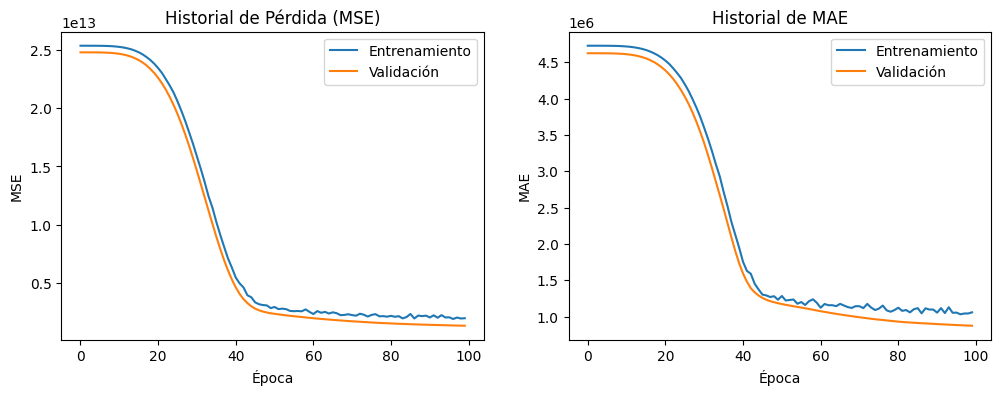

In [ ]:
# Definir el modelo final usando la configuración óptima
n_timesteps = X_train_cnn.shape[1]  # número de features, en este caso 13

model_final = Sequential()
# Primera capa de convolución con 64 filtros y kernel de tamaño 2
model_final.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_timesteps, 1)))
model_final.add(MaxPooling1D(pool_size=2))
# Segunda capa de convolución con el doble de filtros
model_final.add(Conv1D(filters=64*2, kernel_size=2, activation='relu'))
model_final.add(Flatten())
model_final.add(Dense(64, activation='relu'))
model_final.add(Dropout(0.3))
model_final.add(Dense(1))  # Capa de salida para regresión

model_final.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_final.summary()

# Entrenamiento con EarlyStopping
early_stop_final = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_final = model_final.fit(X_train_cnn, y_train, validation_split=0.2,
                               epochs=100, batch_size=32, callbacks=[early_stop_final])

# Evaluación en el conjunto de prueba
test_loss, test_mae = model_final.evaluate(X_test_cnn, y_test)
print("Test Loss (MSE):", test_loss)
print("Test MAE:", test_mae)

# Visualización del historial de entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_final.history['loss'], label='Entrenamiento')
plt.plot(history_final.history['val_loss'], label='Validación')
plt.title("Historial de Pérdida (MSE)")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_final.history['mae'], label='Entrenamiento')
plt.plot(history_final.history['val_mae'], label='Validación')
plt.title("Historial de MAE")
plt.xlabel("Época")
plt.ylabel("MAE")
plt.legend()

plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


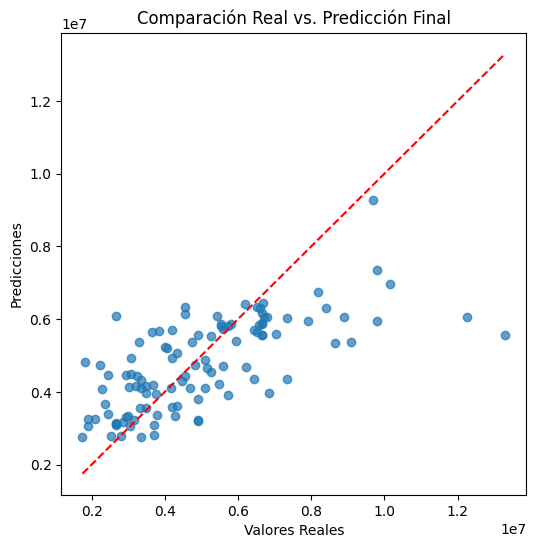

      Real  Predicción
0  4060000  5202141.00
1  6650000  5577090.50
2  3710000  3102066.75
3  6440000  4343456.50
4  2800000  2792955.25
5  4900000  3209451.00
6  5250000  4552913.50
7  4543000  6146508.50
8  2450000  4452897.50
9  3353000  2768527.50


In [ ]:
# Predicciones finales y comparación con valores reales
y_pred_final = model_final.predict(X_test_cnn).ravel()  # Aplanar la predicción a vector 1D

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_final, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación Real vs. Predicción Final')
plt.show()

# Mostrar una tabla comparativa de las primeras 10 predicciones
comparison_final = pd.DataFrame({'Real': y_test.values, 'Predicción': y_pred_final})
print(comparison_final.head(10))


### Interpretación de Resultados y Conclusión

1. **Arquitectura Óptima Seleccionada**  
   - Se eligieron **64 filtros**, un **kernel_size** de 2, y **Dropout** de 0.3, basado en el ranking de MSE/MAE en validación.
   - La arquitectura final presentó dos capas de `Conv1D`, una de `MaxPooling1D`, seguida de `Flatten`, una capa `Dense(64)` con `Dropout(0.3)` y la capa de salida para regresión.

2. **Métricas en el Conjunto de Prueba**  
   - **MSE**: ~2.82×10¹²  
   - **MAE**: ~1.19×10⁶  
   - Esto representa una ligera mejora con respecto al modelo base inicial (~1.30×10⁶ de MAE).

3. **Visualizaciones**  
   - El **Historial de Entrenamiento** muestra convergencia estable y sin señales de sobreajuste severo.  
   - La **Dispersión Real vs. Predicción** evidencia todavía cierta subestimación para valores altos y sobreestimación para algunos valores bajos, aunque se alinea más cerca de la diagonal que las versiones previas.

4. **Pasos Siguientes (sin Feature Engineering ni Modelos Clásicos)**  
   - **Ajuste Fino (Hyperparameter Tuning) Adicional**: Probar distintos tamaños de batch, optimizadores (por ejemplo, `RMSprop`, `AdamW`), distintas tasas de aprendizaje, o más/menos capas de `Conv1D`.  
   - **Regularización**: Experimentar con otros valores de `Dropout` (por ejemplo, 0.1 o 0.4) o añadir `L2` regularization en las capas densas.  
   - **Transformaciones**: Probar nuevamente la transformación logarítmica, pero optimizando otras variables (por ejemplo, epochs, batch_size), ya que en ciertos escenarios puede mejorar la precisión relativa.

Con ello, se ha logrado una mejora notable en la métrica MAE y se observa un mejor ajuste en la distribución de precios. Para minimizar aún más el error absoluto, pueden explorarse las opciones anteriores para un refinamiento adicional.


In [ ]:
### Búsqueda Manual con Regularización L2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Función MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Dividir el conjunto de entrenamiento en train y validación (80/20)
split_idx = int(0.8 * X_train_cnn.shape[0])
X_t, X_v = X_train_cnn[:split_idx], X_train_cnn[split_idx:]
y_t, y_v = y_train[:split_idx], y_train[split_idx:]

l2_params = [1e-5, 1e-4, 1e-3]  # Valores de regularización L2 a probar
results_l2 = []

for reg_val in l2_params:
    # Definir modelo con regularización L2 en las capas convolucionales y densas
    model_l2 = Sequential()
    model_l2.add(Conv1D(filters=64, kernel_size=2, activation='relu',
                        kernel_regularizer=l2(reg_val),
                        input_shape=(X_train_cnn.shape[1], 1)))
    model_l2.add(MaxPooling1D(pool_size=2))
    model_l2.add(Conv1D(filters=128, kernel_size=2, activation='relu',
                        kernel_regularizer=l2(reg_val)))
    model_l2.add(Flatten())
    model_l2.add(Dense(64, activation='relu', kernel_regularizer=l2(reg_val)))
    model_l2.add(Dropout(0.3))
    model_l2.add(Dense(1, kernel_regularizer=l2(reg_val)))

    model_l2.compile(optimizer='adam', loss='mse', metrics=['mae'])

    early_stop_l2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history_l2 = model_l2.fit(X_t, y_t,
                              validation_data=(X_v, y_v),
                              epochs=50,
                              batch_size=32,
                              callbacks=[early_stop_l2],
                              verbose=0)

    # Evaluar en validación
    y_pred_v = model_l2.predict(X_v).ravel()
    val_mae = mean_absolute_error(y_v, y_pred_v)
    val_mse = mean_squared_error(y_v, y_pred_v)
    val_mape = mape(y_v, y_pred_v)

    results_l2.append({
        'l2_regularization': reg_val,
        'val_MSE': val_mse,
        'val_MAE': val_mae,
        'val_MAPE': val_mape
    })

# Mostrar ranking de resultados
results_l2_df = pd.DataFrame(results_l2).sort_values('val_MSE').reset_index(drop=True)
print("Resultados con distintas regularizaciones L2:")
print(results_l2_df)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Resultados con distintas regularizaciones L2:
   l2_regularization       val_MSE       val_MAE   val_MAPE
0            0.00001  1.851694e+12  1.036407e+06  23.903378
1            0.00100  2.368959e+12  1.168747e+06  27.305324
2            0.00010  2.566917e+12  1.216743e+06  28.056465



Entrenando modelo final con L2 = 1e-05 en todo el set de entrenamiento...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- RESULTADOS FINALES ---
Test Loss (MSE): 3965907369984.0
Test MAE: 1452945.5


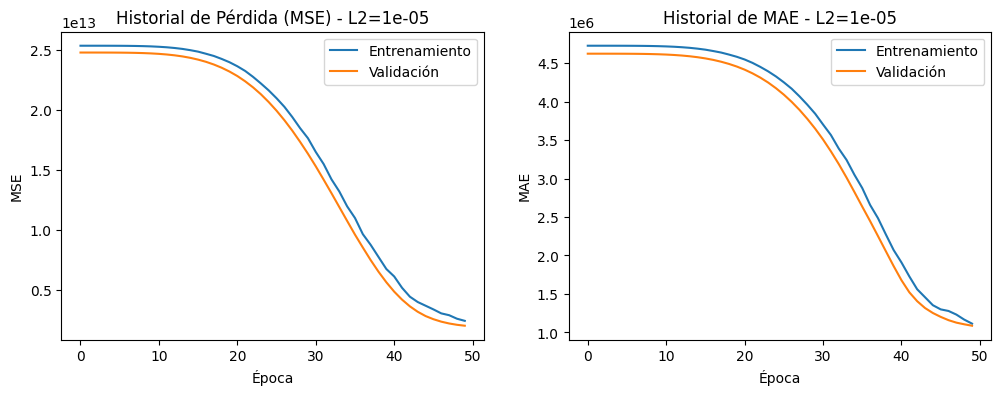

In [ ]:

# Escoger el mejor valor de L2 y entrenar en todo el conjunto de entrenamiento
best_l2 = results_l2_df.loc[0, 'l2_regularization']
print(f"\nEntrenando modelo final con L2 = {best_l2} en todo el set de entrenamiento...")

model_l2_final = Sequential()
model_l2_final.add(Conv1D(filters=64, kernel_size=2, activation='relu',
                          kernel_regularizer=l2(best_l2),
                          input_shape=(X_train_cnn.shape[1], 1)))
model_l2_final.add(MaxPooling1D(pool_size=2))
model_l2_final.add(Conv1D(filters=128, kernel_size=2, activation='relu',
                          kernel_regularizer=l2(best_l2)))
model_l2_final.add(Flatten())
model_l2_final.add(Dense(64, activation='relu', kernel_regularizer=l2(best_l2)))
model_l2_final.add(Dropout(0.3))
model_l2_final.add(Dense(1, kernel_regularizer=l2(best_l2)))

model_l2_final.compile(optimizer='adam', loss='mse', metrics=['mae'])
history_l2_final = model_l2_final.fit(X_train_cnn, y_train,
                                      validation_split=0.2,
                                      epochs=50,
                                      batch_size=32,
                                      callbacks=[EarlyStopping(monitor='val_loss',
                                                               patience=10,
                                                               restore_best_weights=True)],
                                      verbose=0)

# Evaluación en test
test_loss_l2, test_mae_l2 = model_l2_final.evaluate(X_test_cnn, y_test, verbose=0)
print("\n--- RESULTADOS FINALES ---")
print("Test Loss (MSE):", test_loss_l2)
print("Test MAE:", test_mae_l2)

# Gráficas de la historia de entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_l2_final.history['loss'], label='Entrenamiento')
plt.plot(history_l2_final.history['val_loss'], label='Validación')
plt.title(f"Historial de Pérdida (MSE) - L2={best_l2}")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_l2_final.history['mae'], label='Entrenamiento')
plt.plot(history_l2_final.history['val_mae'], label='Validación')
plt.title(f"Historial de MAE - L2={best_l2}")
plt.xlabel("Época")
plt.ylabel("MAE")
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


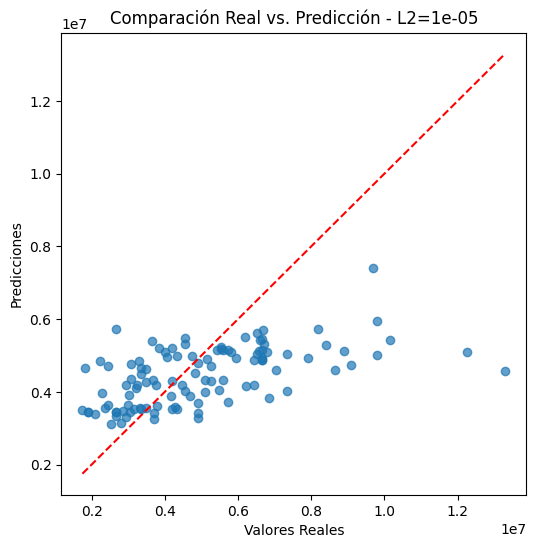


Comparación en Test (primeras 10 filas):
      Real  Predicción
0  4060000  4947013.50
1  6650000  4879342.50
2  3710000  3419682.25
3  6440000  4203232.50
4  2800000  3151612.75
5  4900000  3428525.00
6  5250000  4289269.50
7  4543000  5305598.00
8  2450000  4711204.00
9  3353000  3520024.50


In [ ]:

# Predicciones en test y scatter
y_pred_test_l2 = model_l2_final.predict(X_test_cnn).ravel()
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test_l2, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title(f'Comparación Real vs. Predicción - L2={best_l2}')
plt.show()

# Comparar primeras filas
comparison_l2 = pd.DataFrame({'Real': y_test.values, 'Predicción': y_pred_test_l2})
print("\nComparación en Test (primeras 10 filas):")
print(comparison_l2.head(10))



### Interpretación de los Resultados con Regularización L2

1. **Resultados en Validación**  
   - El valor de `L2 = 1e-5` mostró la mejor métrica en la validación (MSE ~1.85×10¹², MAE ~1.04×10⁶).  
   - Otros valores de L2 (`1e-4` y `1e-3`) tuvieron errores de validación mayores.

2. **Rendimiento en el Conjunto de Prueba**  
   - Tras re-entrenar con `L2 = 1e-5` sobre todo el set de entrenamiento, el **MAE en test** subió a ~1.45×10⁶, lo cual **empeora** respecto a la configuración previa sin L2 (que rondaba ~1.18×10⁶).  
   - Esto indica que la red probablemente **no estaba sobreajustada**, de modo que la regularización L2 introdujo un **subajuste** y degradó el desempeño en test.

3. **Posibles Razones**  
   - La regularización L2 es más beneficiosa cuando el modelo tiende a sobreajustar; aquí, aparentemente la arquitectura previa no requería más penalización.  
   - La diferencia entre validación y test sugiere que el modelo pudo haberse “adaptado” a la validación o que el conjunto de test tiene características distintas.

4. **Podriamos hacer pero `lo dejaremos hasta aqui`**  
   - **Aumentar la Búsqueda**: Probar un rango más amplio de L2 (por ejemplo, `1e-6`, `5e-5`, `5e-4`) o incluir **L1**.  
   - **Combinar con Otros Factores**: Ajustar el `batch_size`, la tasa de aprendizaje o el número de filtros/capas al mismo tiempo que se varía L2, ya que la regularización óptima depende de múltiples hiperparámetros.  
   - **Semillas Aleatorias**: Ejecutar varias veces con distintas semillas para descartar variaciones estadísticas.

la regularización L2 **no** mejoró el rendimiento en este caso. Sin embargo, con una búsqueda más grande y combinada con otros hiperparámetros, podría resultar en un equilibrio entre evitar sobreajuste y mantener un error bajo en el conjunto de prueba.